# Inspect Extracted Noise

We extract "noise" in the `seasonal-decomposition` step. 
Here we analyse it via a **scatter matrix** to inspect correlations with the features.

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings

# Suppress the FutureWarning coming from Seaborn KDE computation
warnings.simplefilter(action='ignore', category=FutureWarning)

from pathlib import Path

In [12]:
FIELD = "US-CF1"
BLUE = "#0085F9"
RED = "#FF0052"

root = Path(r"..\data\us_cf1_fede")

df_noise = pd.read_pickle(root / "data\postprocessed" / "kc_noise.pickle").to_frame().reset_index()
df_noise.rename(columns={'resid': "Residual"}, inplace=True)
df_noise.index

RangeIndex(start=0, stop=1077, step=1)

## Scatter Plotting Noise

<Axes: >

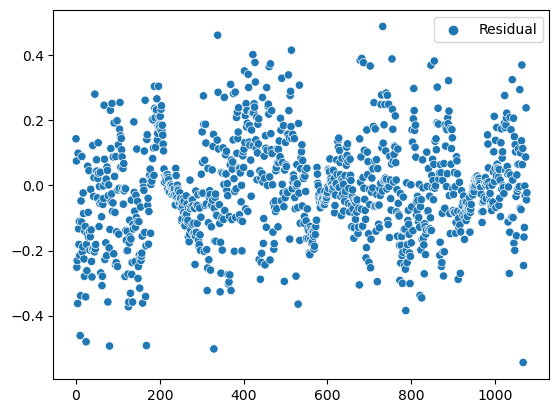

In [3]:
sns.scatterplot(df_noise)

### Noise colored by Day of Month

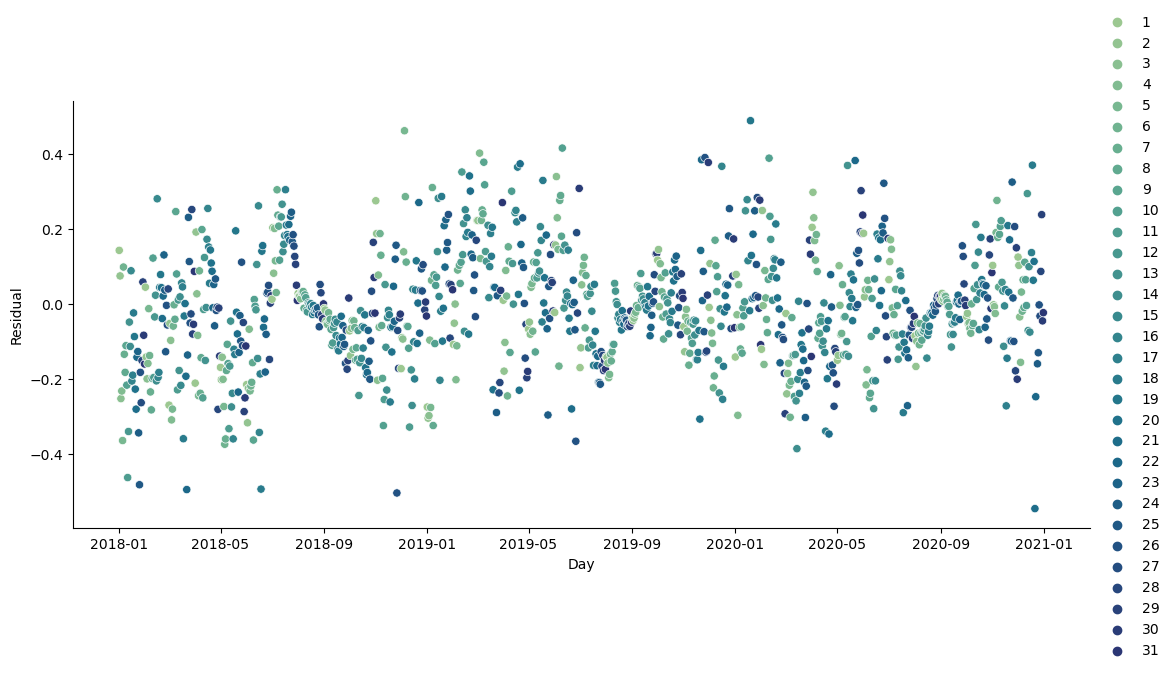

In [4]:
sns.relplot(df_noise, x="Day", y="Residual", kind="scatter", 
            hue=df_noise.apply(lambda x: str(x.loc["Day"].day), axis=1), palette="crest", 
            aspect=20/9)

*There is no evident pattern emerging from this figure, only that, **in Winter, values are more spread***.

## Correlation with Features

### Read Features Data

In [5]:
features_used = ["DOY", "Tmin", "Tmax", "Tdew", "Uwind", "Vwind", "Rs", "ETa"] 
df_fts = pd.read_pickle(root / "data/raw/data.pickle").loc[:, features_used].reset_index()
df_fts

,Day,DOY,Tmin,Tmax,Tdew,Uwind,Vwind,Rs,ETa
0,2018-01-01,1.0,264.740,272.864,267.268,-1.402,-0.322,4939624.0,NaN
1,2018-01-02,2.0,262.271,273.478,265.119,-1.777,-0.352,6175936.0,0.20
2,2018-01-03,3.0,268.493,276.668,267.810,-1.225,-0.133,5672220.0,0.07
3,2018-01-04,4.0,264.585,276.557,266.605,-1.708,-0.150,5239328.0,0.12
4,2018-01-05,5.0,270.797,277.016,270.668,-2.052,0.232,2916484.0,0.02
...,...,...,...,...,...,...,...,...,...
1091,2020-12-27,362.0,270.230,275.713,271.923,-0.536,0.898,3319976.0,0.02
1092,2020-12-28,363.0,269.012,275.350,268.533,-1.703,0.201,6064016.0,0.13
1093,2020-12-29,364.0,269.215,273.384,268.460,-0.012,0.310,3461076.0,NaN
1094,2020-12-30,365.0,271.150,272.801,269.756,-2.044,1.283,1596552.0,NaN


### Merge with Noise Data

pandas.core.series.Series

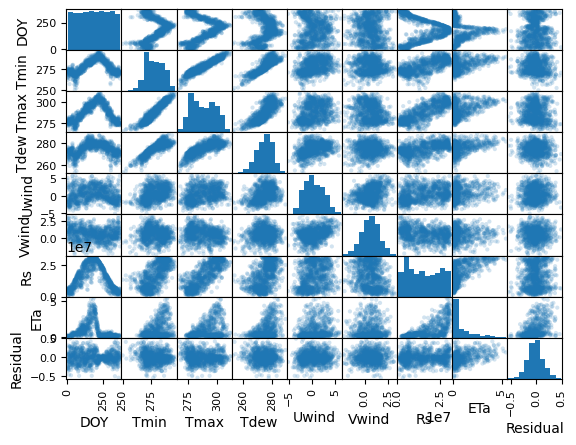

In [6]:
df = df_fts.merge(df_noise, on="Day")
pd.plotting.scatter_matrix(df, alpha=0.2)
type(df.corr(numeric_only=True)["Residual"])

### Plot Correlations

In [7]:
df_melted = df.melt(id_vars=["Residual"], var_name="Feature")
df_melted

,Residual,Feature,value
0,0.143547,Day,2018-01-01 00:00:00
1,0.075473,Day,2018-01-02 00:00:00
2,-0.251399,Day,2018-01-03 00:00:00
3,-0.231125,Day,2018-01-04 00:00:00
4,-0.363073,Day,2018-01-05 00:00:00
...,...,...,...
9688,-0.031441,ETa,0.02
9689,0.087492,ETa,0.13
9690,0.238736,ETa,NaN
9691,-0.044262,ETa,NaN


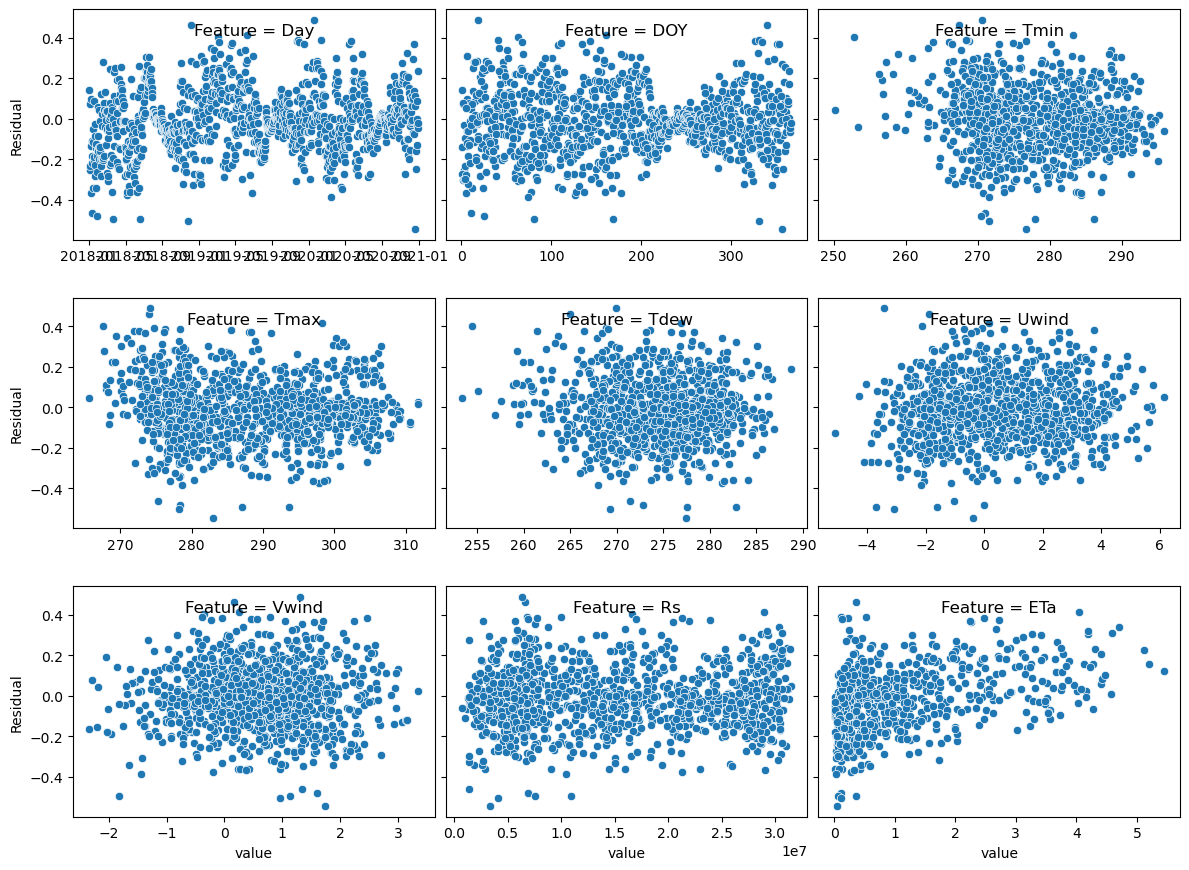

In [8]:
def plot_correlation(data, x, y):
    g = sns.relplot(data, x=x, y=y, 
                    col="Feature", col_wrap=3, 
                    facet_kws={"sharey":True, "sharex":False}, height=3, aspect=4/3)
    # for i, f in enumerate(features_used):
    #     g.axes[i].set_xlabel(f)

    # Draw lines for the upper and right sides of each axis
    for ax in g.axes.flat:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)

    # Adjust the titles of each subplot
    for ax in g.axes.flat:
        ax.set_title(ax.get_title(), y=.85)  # Adjust the y value as needed

    g.figure.subplots_adjust(wspace=0.03)

    plt.show()
    return g

g = plot_correlation(df_melted, "value", "Residual")

## Probability Distribution Function

*TODO: Uniformare le scale*

<Axes: title={'center': 'US-CF1'}, xlabel='Residual', ylabel='Density'>

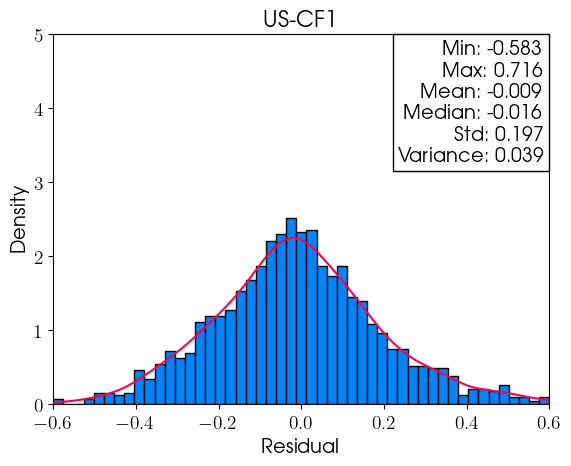

In [109]:
def get_statistics(data):
    minimum = data.min()
    maximum = data.max()
    mean = data.mean()
    median = data.median()
    std = data.std()
    var = data.var()  # Unbiased variance normalized by N-1
    statistics = pd.DataFrame(
        [minimum, maximum, mean, median, std, var],
        index = ["Min", "Max", "Mean", "Median", "Std", "Variance"],
    )
    stats_string = '\n'.join((
        f"Min: {minimum:.3f}",
        f"Max: {maximum:.3f}",
        f"Mean: {mean:.3f}",
        f"Median: {median:.3f}",
        f"Std: {std:.3f}",
        f"Variance: {var:.3f}",
    ))
    return stats_string, statistics
    

def plot_statistics(data, ax, field=FIELD, x=None, statistics=None):
    bins = np.linspace(-0.6, 0.6, 50)
    if x is not None:
        ax.hist(data[x], bins=bins, density=True, label=str(x), ec="k", color=BLUE)
    else:
        ax.hist(data, bins=bins, density=True, label='Data', ec="k", color=BLUE)

     # Add KDE plot
    sns.kdeplot(data, ax=ax, color=RED)
        
    ax.set_xlabel('Residual')
    ax.set_ylabel('Density')
    ax.set_title(field, fontsize=16)
    ax.set_xlim(-0.6, 0.6)
    ax.set_ylim(0.0, 5.0)
    
    if statistics:
        boxprops = dict(ec='black', fc='white')
        ax.text(0.586, 4.93, statistics, fontsize=14, verticalalignment='top', horizontalalignment='right', bbox=boxprops)
    
    return ax
    
fig, ax = plt.subplots()
statistics, csv = get_statistics(df_noise["Residual"])
csv.to_csv("kc_noise_Stats.csv", header=False)
plot_statistics(df_noise["Residual"], ax, statistics=statistics)

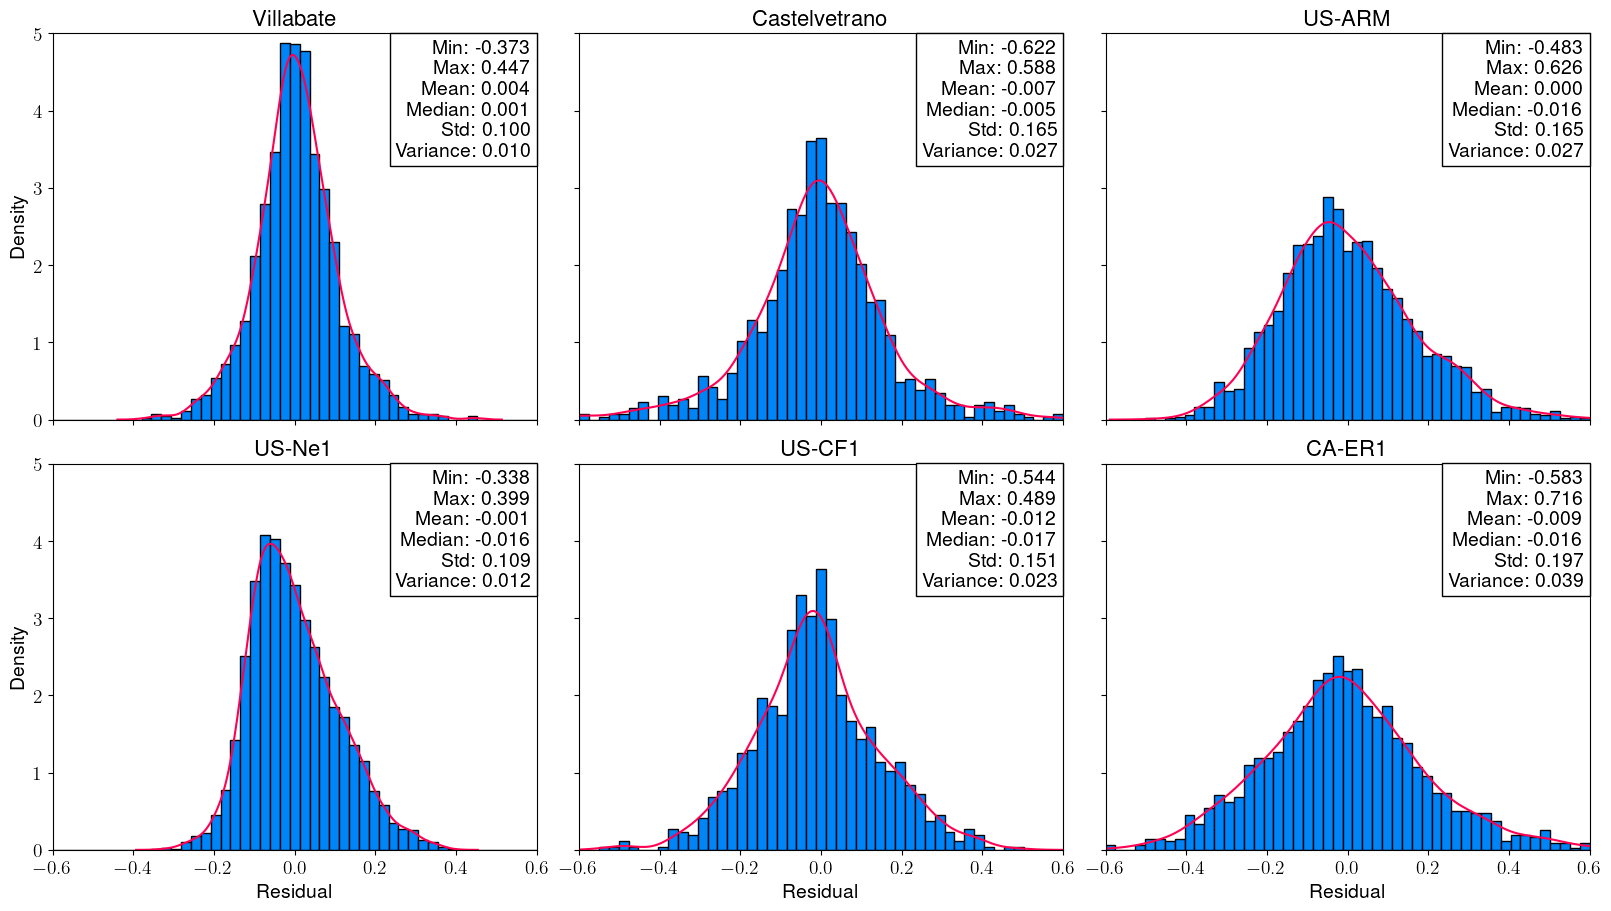

In [111]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": 14,
})

FIELDS = {
    "Villabate": "data\\villabate_fede",
    "Castelvetrano": "data\\castelvetrano_fede",
    "US-ARM": "data\\us_arm_fede",
    "US-Ne1": "data\\us_ne1_fede",
    "US-CF1": "data\\us_cf1_fede",
    "CA-ER1": "data\\ca_er1_fede",
}
# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

fig, axs = plt.subplots(2, 3, figsize=(16, 9), layout='constrained', sharey=True, sharex=True)
axs = axs.flatten()

for i, (field, folder) in enumerate(FIELDS.items()):
    df_noise = pd.read_pickle(f"..\{folder}\data\postprocessed\kc_noise.pickle").to_frame().reset_index()
    df_noise.rename(columns={'resid': "Residual"}, inplace=True)
    statistics, csv = get_statistics(df_noise["Residual"])
    csv.to_csv(f"..\{folder}\data\postprocessed\kc_noise_Stats.csv", header=False)
    plot_statistics(df_noise["Residual"], axs[i], field, statistics=statistics)

fig.savefig("..\\visualization\\residual_distributions.png")
fig.savefig("..\\visualization\\residual_distributions.eps")